In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install wandb

In [4]:
import wandb
wandb.login()
#ec0fa02abb6680e2e41f9e94ffb3c3a636ca9007

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [46]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
import numpy as np
import random
import time
import copy

import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator 

In [32]:
train_config = {"EPOCHS" : 15,
"data_path" : '/content/drive/MyDrive/AI Project/Dataset1/PlantVillage_15 classes',
"width":256,
"height":256,
"batch_size" : 64,
"num_classes":15}

In [7]:
run = wandb.init(project="shuffleNet2", config=train_config)

wandb: Currently logged in as: prvns1997 (p1). Use `wandb login --relogin` to force relogin


In [16]:
leaf_datasets = datasets.ImageFolder(
    train_config['data_path'],
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [28]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

# splitting total dataset into train and validation
train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.3, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)

# splitting validation dataset into validation and test dataset
val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.7, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [29]:
print('datapoints in  train dataset:',len(dataset['train']))
print('datapoints in validation dataset:',len(dataset['valid']))
print('datapoints in test dataset:',len(dataset['test']))

datapoints in  train dataset: 14411
datapoints in validation dataset: 1853
datapoints in test dataset: 4324


In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [36]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [41]:
#setting the device
device = get_default_device()

In [30]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=train_config['batch_size'], shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=train_config['batch_size'], shuffle=False,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=train_config['batch_size'], shuffle=False,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train/valid/test : %d / %d / %d' % (train_config['batch_size'], batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  train/valid/test : 226 / 29 / 68


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


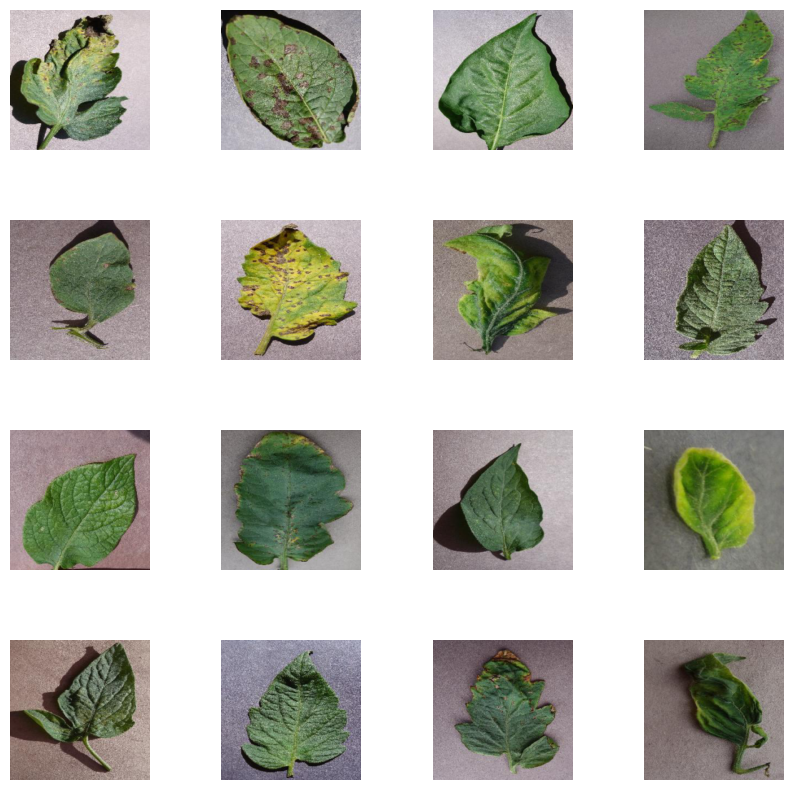

In [33]:
#Visualizing some of datapoints
# Get a batch of images from the train loader
images, labels = next(iter(dataloaders['train']))

# Convert the PyTorch tensor to a NumPy array
images = images.numpy()

# Convert the NumPy array to a PyTorch tensor
images = torch.from_numpy(images)

# Denormalize the images
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
images = images.permute(0, 2, 3, 1)  # Change the order of the dimensions
images = std * images + mean

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5) # Adjust subplot parameters
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(images[i])
    ax.axis('off')
plt.show()


In [34]:
# defining the modeling
from torchvision import models
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.shufflenet_v2_x2_0(weights = None,num_classes=classes,progress=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [42]:
#connverting dataloader to GPU
dataloaders['train'] = DeviceDataLoader(dataloaders['train'], device)
dataloaders['valid'] = DeviceDataLoader(dataloaders['valid'], device)
dataloaders['test'] = DeviceDataLoader(dataloaders['test'], device)

In [45]:
model = to_device(PlantDiseaseModel(classes=train_config['num_classes']), device) 
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
model


PlantDiseaseModel(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [54]:
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0
since = time.time()
best_model = copy.deepcopy(model.state_dict())

for epoch in range(train_config['EPOCHS']):    
    trn_loss, trn_corrects, val_loss, val_corrects,total_train_images,total_val_images = 0.0, 0, 0.0, 0,0,0
    
    model.train()
    for i, (data, target) in tqdm(enumerate(dataloaders['train'])):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        trn_loss += loss.item() * target.size(0)
        _, predicted = torch.max(output, 1)
        trn_corrects += (predicted == target).sum().item()
        total_train_images += target.size(0)

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in tqdm(enumerate(dataloaders['valid'])):
            val_data, val_target = val_data.to(device), val_target.to(device)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            val_loss += loss.item() * val_target.size(0)
            _, predicted = torch.max(val_output, 1)
            val_corrects += (predicted == val_target).sum().item()
            total_val_images += val_target.size(0)

    #accuracies
    trn_acc_list.append(trn_corrects/total_train_images)
    val_acc_list.append(val_corrects/total_val_images)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    wandb.log({'epoch':(epoch+1)/train_config['EPOCHS'],'training_loss': trn_loss/batch_num['train'],'validation_loss': val_loss/batch_num['valid']})
    wandb.log({'epoch':(epoch+1)/train_config['EPOCHS'],'training_acc': trn_corrects/total_train_images,'validation_acc': val_corrects/total_val_images})
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, train_config['EPOCHS'], trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))
    
    if val_corrects/total_val_images > best_acc:
      best_acc = val_corrects/total_val_images
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet2/best_model.pt')
print("model saved")

0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
226it [01:13,  3.09it/s]
29it [00:07,  3.87it/s]


epoch: 1/15 | trn loss: 160.1949 | val loss: 156.5749 | 1m 21s elapsed
best model updated-epoch: 1 | val_accuracy: 0.3189


226it [01:12,  3.13it/s]
29it [00:07,  3.90it/s]


epoch: 2/15 | trn loss: 159.7764 | val loss: 163.7071 | 2m 40s elapsed


226it [01:12,  3.12it/s]
29it [00:07,  3.84it/s]


epoch: 3/15 | trn loss: 159.4129 | val loss: 157.9504 | 4m 0s elapsed
best model updated-epoch: 3 | val_accuracy: 0.3216


226it [01:15,  2.99it/s]
29it [00:09,  2.90it/s]


epoch: 4/15 | trn loss: 159.0431 | val loss: 158.5499 | 5m 26s elapsed
best model updated-epoch: 4 | val_accuracy: 0.3421


226it [01:10,  3.21it/s]
29it [00:09,  2.92it/s]


epoch: 5/15 | trn loss: 158.6749 | val loss: 170.7536 | 6m 46s elapsed
best model updated-epoch: 5 | val_accuracy: 0.3513


226it [01:10,  3.22it/s]
29it [00:09,  2.92it/s]


epoch: 6/15 | trn loss: 158.2728 | val loss: 153.7810 | 8m 7s elapsed
best model updated-epoch: 6 | val_accuracy: 0.3556


226it [01:10,  3.22it/s]
29it [00:09,  2.92it/s]


epoch: 7/15 | trn loss: 157.8822 | val loss: 164.2785 | 9m 27s elapsed
best model updated-epoch: 7 | val_accuracy: 0.3600


226it [01:10,  3.20it/s]
29it [00:10,  2.89it/s]


epoch: 8/15 | trn loss: 157.3276 | val loss: 167.1700 | 10m 47s elapsed
best model updated-epoch: 8 | val_accuracy: 0.3654


226it [01:10,  3.22it/s]
29it [00:09,  2.93it/s]


epoch: 9/15 | trn loss: 156.8762 | val loss: 162.9932 | 12m 8s elapsed
best model updated-epoch: 9 | val_accuracy: 0.3697


226it [01:10,  3.19it/s]
29it [00:09,  2.93it/s]


epoch: 10/15 | trn loss: 156.2056 | val loss: 155.7533 | 13m 28s elapsed


226it [01:09,  3.23it/s]
29it [00:10,  2.87it/s]


epoch: 11/15 | trn loss: 155.5667 | val loss: 151.0407 | 14m 48s elapsed
best model updated-epoch: 11 | val_accuracy: 0.4010


226it [01:10,  3.22it/s]
29it [00:09,  2.96it/s]


epoch: 12/15 | trn loss: 154.7949 | val loss: 153.8606 | 16m 9s elapsed
best model updated-epoch: 12 | val_accuracy: 0.4177


226it [01:09,  3.24it/s]
29it [00:09,  2.93it/s]


epoch: 13/15 | trn loss: 154.0875 | val loss: 158.3308 | 17m 28s elapsed
best model updated-epoch: 13 | val_accuracy: 0.4307


226it [01:09,  3.25it/s]
29it [00:09,  2.91it/s]


epoch: 14/15 | trn loss: 153.4263 | val loss: 151.2362 | 18m 48s elapsed


226it [01:09,  3.24it/s]
29it [00:09,  3.03it/s]

epoch: 15/15 | trn loss: 152.9180 | val loss: 160.9641 | 20m 7s elapsed
best model updated-epoch: 15 | val_accuracy: 0.4436
Training complete in 20m 7s
Best valid Acc: 0.4
model saved


In [ ]:
!pwd

In [55]:
print(trn_loss_list)

[160.19493103660312, 159.77644934274454, 159.41288853219126, 159.0431241503859, 158.67492696563755, 158.27275935527499, 157.8822437725236, 157.32761168585415, 156.8762006685797, 156.20564082238528, 155.5666703101808, 154.79492197205536, 154.08748025282296, 153.4263183258276, 152.9179611111109]


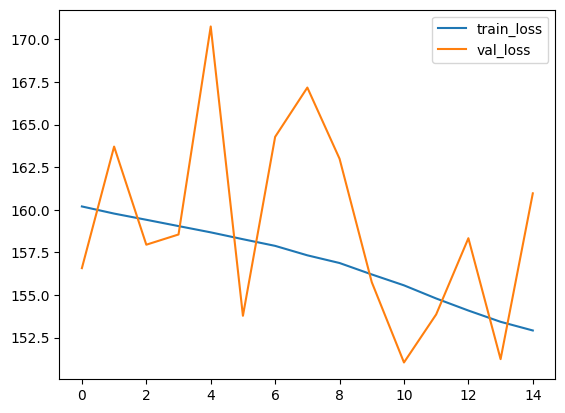

In [56]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

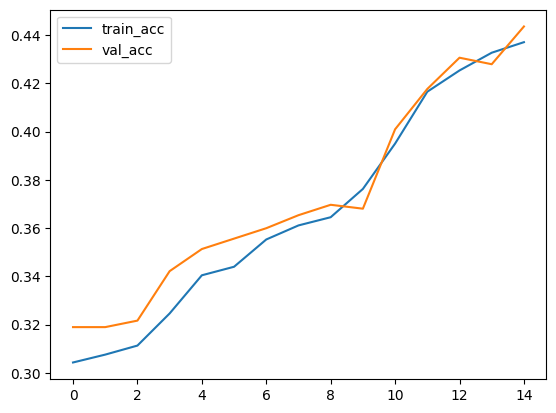

In [57]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [59]:
corrects = 0
total = 0
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model.to(device)
best_model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(device), target.to(device)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


1886/4324 | test accuracy: 0.4362


In [62]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
best_model = PlantDiseaseModel(classes =15)
best_model.load_state_dict(torch.load('ShuffleNet2/best_model.pt'))
best_model = best_model.to(device)
# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in dataloaders['test']:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Precision: 0.1615, Recall: 0.2741, F-score: 0.1950
Confusion matrix:
 [[  0   0   0   0   0   0   0  22   0  93  74   0  29   0   0]
 [  0   0   0   0   0  23   0  26   0  91 172   0  10   0   0]
 [  0   0   0   0   0   7   0   0   0  50 173   0   0   0   0]
 [  0   0   0   0   0  62   0  10   0   2 109   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  16   6   0   0   0   0]
 [  0   0   0   0   0 384   0  28   0   0   0   0   8   0   0]
 [  0   0   0   0   0  41   0  70   0  18  39   0  14   0   0]
 [  0   0   0   0   0  28   0 249   0  16  89   0  27   0   0]
 [  0   0   0   0   0   8   0  23   0  62  89   0  18   0   0]
 [  0   0   0   0   0   4   0  19   0 298  49   0   3   0   0]
 [  0   0   0   0   0   3   0  27   0  24 278   0   1   0   0]
 [  0   0   0   0   0  13   0   2   0  82 189   0   2   0   0]
 [  0   0   0   0   0   2   0  22   0   7   1   0 677   0   0]
 [  0   0   0   0   0   0   0   1   0  66   3   0   8   0   0]
 [  0   0   0   0   0  74   0  62   0  35 186   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


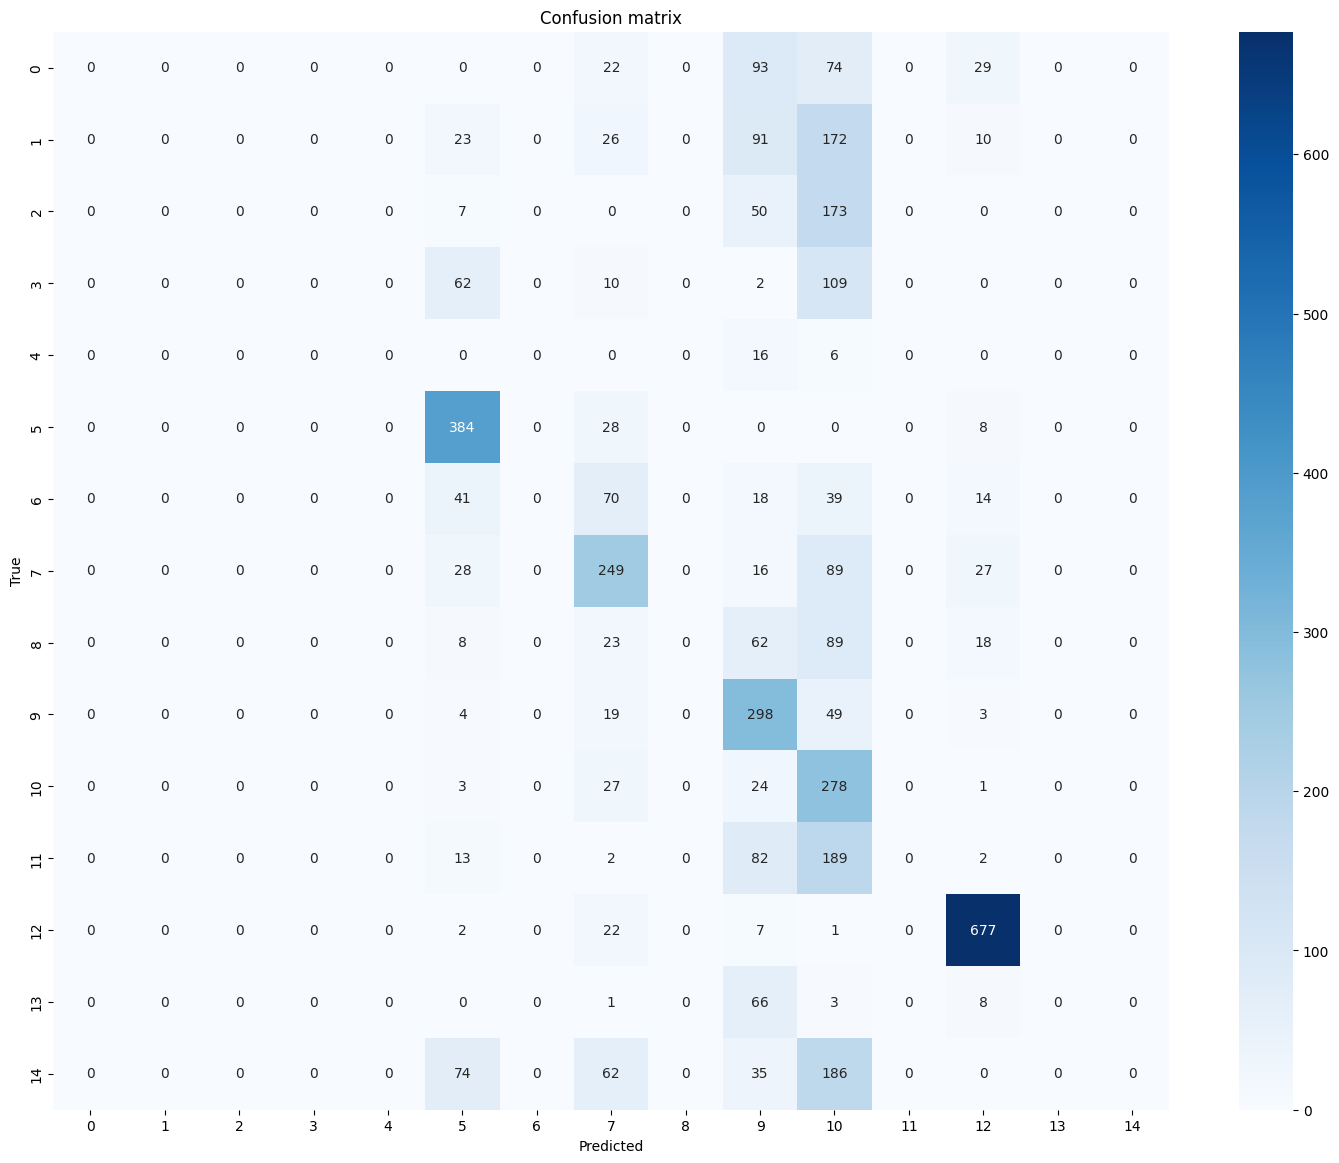

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
